# How much will coffee cost, tomorrow?

<img src="coffee.jpg">

Coffee is a relatable, lovable, two sided market. It serves as a cash crop for developing countries, providing a primary source of income for over 100 million people. In 2011 the coffee industry was valued at over 20 billion dollars, and coffee futures are traded on key finance exchanges every day alongside oil and gold. 

Coffee production occurs primarily in Brazil, Vietnam, Indonesia, and Columbia, with Brazil producing nearly twice as much coffee as Vietnam. Various beans are common to specific parts of the world, and hold different levels of value based on their perceived quality. Most of the world’s coffee industry, and therefore the price of coffee, is controlled by Kraft, Nestle, P&G, and Sara Lee. As one can see, there are a limited number of factors affecting the price of coffee as a commodity.
    
Because coffee futures are publicly traded, there is a huge incentive to accurately model the future price of the good. Some of the factors worth considering are weather forecasting in countries of production, changes in demand, economics of export and import laws, and the price of raw materials. This information can be freely accessed and integrated into a predictive model.

#Table of Contents

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

To conduct datascience, we first need data. Quandl will serve as a reliable starting ground for well formatted information.

In [5]:
import requests
import json

#get coffee price data for arabica and robusta
page_a = requests.get("https://www.quandl.com/api/v3/datasets/CEPEA/COFFEE_A.json", params={"start_date": "2002-01-01", "end_date": "2011-12-31", "order": "asc"})
page_r = requests.get("https://www.quandl.com/api/v3/datasets/CEPEA/COFFEE_R.json", params={"start_date": "2002-01-01", "end_date": "2011-12-31", "order": "asc"})

df = pd.DataFrame(page_a.json()["dataset"]["data"], columns=["date", "arabica price"])
df['robusta price'] = pd.DataFrame(page_r.json()["dataset"]["data"], columns=["date", "price"])["price"]

In [6]:
#get futures price data
page_futures = requests.get("https://www.quandl.com/api/v3/datasets/CHRIS/ICE_KC2.json", params={"start_date": "2002-01-01", "end_date": "2011-12-31", "order": "asc"})
futures_dict = dict([(day[0],day[1]) for day in page_futures.json()["dataset"]["data"]])

In [72]:
#clean futures data so dates match, add to df
futures = []
for d in df["date"]:
    if d in futures_dict:
        price = futures_dict[d]
    futures.append(price)

df["futures price"] = futures
df["date"] = pd.to_datetime(df['date'])

In [73]:
df.head()

,date,arabica price,robusta price,futures price
0,2002-01-02,45.473090,21.532118,49.25
1,2002-01-03,46.165577,21.607843,49.30
2,2002-01-04,45.668954,21.350772,50.50
3,2002-01-07,45.914163,21.502146,50.35
4,2002-01-08,45.661331,21.027801,50.60


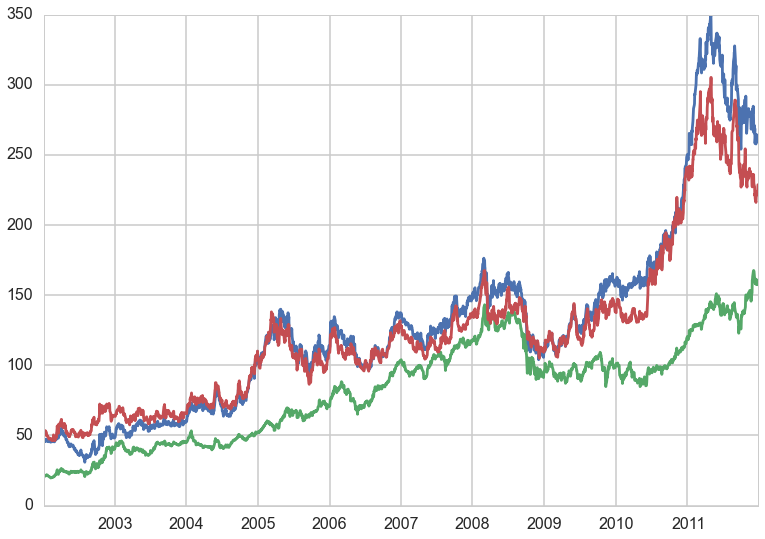

In [81]:
plt.plot(df.date, df["arabica price"])
plt.plot(df.date, df["robusta price"])
plt.plot(df.date, df["futures price"])

One can see that the futures price mirrors that of the price of arabica coffee much more closely than that of robusta.

In [78]:
#annual Brazil production info
page_prod = requests.get("https://www.quandl.com/api/v3/datasets/BCB/1262.json", params={"start_date": "2001-12-31", "end_date": "2010-12-31", "order": "asc"})

prod_df = pd.DataFrame(page_prod.json()["dataset"]["data"], columns=["year", "prv year prod"])
prod_df["year"] = [int(yr.split("-")[0]) + 1 for yr in prod_df["year"]]

In [11]:
prod_df.head()

,year,prv year prod
0,2002,3639138
1,2003,2610524
2,2004,1987074
3,2005,2465710
4,2006,2140169


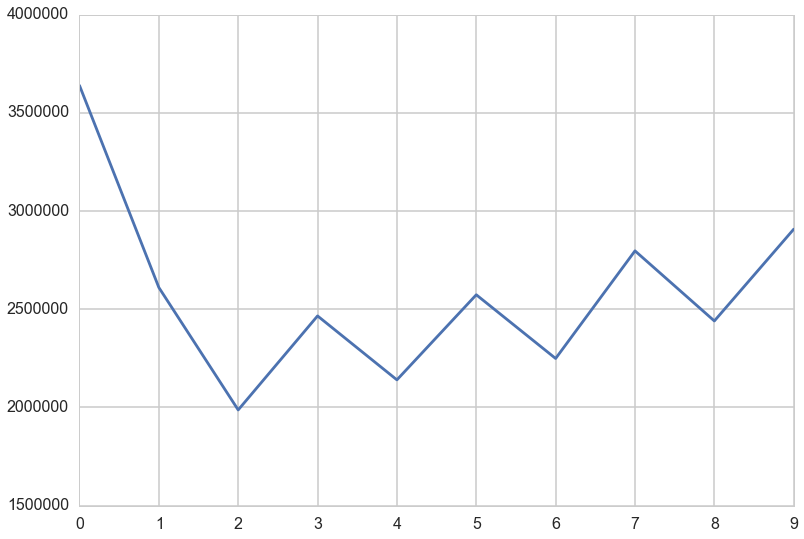

In [12]:
plt.plot(prod_df.index, prod_df["prv year prod"])

resources:
    http://www.investopedia.com/university/commodities/commodities2.asp
    http://www.ico.org/new_historical.asp?section=Statistics
    http://www.wikinvest.com/commodity/Coffee#_note-3

# Weather

Because coffee is a growable commodity, it's production and cost is likely influenced by changes in weather. We hypothesize that better weather in countries with high coffee production will result in lower coffee prices. We can test this hypothesis by first collecting a list of countries and their rate of coffee production. From https://datahero.com/blog/2014/03/28/the-countries-that-drink-the-most-coffee-and-pay-the-highest-prices-for-it/ we can find the ammount of coffee produced by each country every year since 1990 (Thousands of 60kg bags).

In [76]:
prod = pd.DataFrame.from_csv("production.csv")
prod.head()

,Country Code,Season,Type,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Angola,AGO,April,(R/A),50,79,78,33,77,62,71,64,85,55,50,21,57,38,15,25,35,36,38,13,35,29,33,35,39
Bolivia,BOL,April,(A),123,107,123,57,122,152,133,153,150,184,173,118,149,125,170,129,164,133,135,142,130,143,115,128,106
Brazil,BRA,April,(A/R),"27,286","27,293","34,603","28,167","28,192","18,060","29,197","26,148","36,761","47,578","31,310","31,365","48,480","28,820","39,272","32,944","42,512","36,070","45,992","39,470","48,095","43,484","50,826","49,152","45,342"
Burundi,BDI,April,(A),487,667,620,393,664,434,401,250,492,351,487,144,454,338,437,103,499,133,412,112,353,204,406,163,252
Ecuador,ECU,April,(A/R),"1,504","2,124","1,185","2,069","2,376","1,888","1,993","1,191","1,206","1,198",854,793,582,641,780,935,"1,035",950,771,813,854,825,828,666,644


The total changes in production over season and time will be useful in finding correlation with financial pricing. The breakdown of production by country each year will give us the necessary data to weight the average weather by country each season to give us clarity into how weather affects the price of coffee. To do this, we now need to find data on 

It turns out that historical climate data is slightly tricky to aquire. The World Bank offers a great starting point with their free API. By formatting REST requests, we can download monthly rain and temperature data for any country from 1980 to 1999. That leaves 2000-2015 missing, but it give us an accurate starting point.

example: http://climatedataapi.worldbank.org/climateweb/rest/v1/country/mavg/pr/1980/1999/BRA.json

In [65]:
from time import sleep
import wbpy
from pprint import pprint

c_api = wbpy.ClimateAPI()

# for ccode in ['BRA']: #prod['Country Code']:
locations = prod['Country Code']
raindf = pd.DataFrame()
tempdf = pd.DataFrame()
for ccode in locations:
    rain_dataset = c_api.get_instrumental(data_type="pr", interval="year", locations=[ccode]).as_dict().itervalues().next()
    raindf[ccode] = pd.Series(rain_dataset)
    
    temp_dataset = c_api.get_instrumental(data_type="tas", interval="year", locations=[ccode]).as_dict().itervalues().next()
    tempdf[ccode] = pd.Series(temp_dataset)

raindf.to_csv('raindf.csv')
tempdf.to_csv('tempdf.csv')

In [68]:
tempdf.head()

,AGO,BOL,BRA,BDI,ECU,IDN,MDG,MWI,PNG,PRY,PER,RWA,TLS,ZWE,COG,CUB,DOM,HTI,PHL,TZA,ZMB,BEN,CMR,CAF,COL,COD,CRI,CIV,SLV,GNQ,ETH,GAB,GHA,GTM,GIN,GUY,HND,IND,JAM,KEN,LAO,LBR,MEX,NPL,NIC,NGA,PAN,SLE,LKA,THA,TGO,TTO,UGA,VEN,VNM,YEM
1901,21.619059,21.578380,24.896547,20.382895,21.893261,25.897385,22.991997,21.356690,25.309772,24.028030,19.683598,18.663021,25.382143,21.239357,24.470938,24.693453,23.941128,24.307083,26.109781,22.344885,21.574623,27.119736,24.776066,24.906477,24.604921,23.909729,24.762500,26.196789,24.753206,24.384804,23.137266,24.819895,26.817287,23.428870,26.076412,25.689861,23.746578,23.736393,24.583332,24.430460,23.554132,25.696167,20.528100,12.627235,24.950000,26.675690,25.213566,26.678380,26.762500,26.433720,26.766666,25.951666,22.485680,25.327549,24.129597,23.873058
1902,21.620358,21.419336,25.091810,20.382895,21.893261,25.891254,23.347422,21.709507,25.309584,24.114868,19.674818,18.663021,25.379168,21.546436,24.470781,24.928928,23.768011,24.222918,26.026447,22.389864,21.753736,27.310232,24.774754,24.887566,24.599943,23.924086,24.775260,26.368210,24.846153,24.384804,22.980510,24.818018,26.985981,23.555655,26.329615,25.659878,23.906399,23.920109,24.653334,24.461529,23.739426,25.633835,20.804192,12.624289,25.048046,26.748623,25.213566,26.538513,26.605885,26.346150,26.957859,25.900000,22.500080,25.287296,24.392673,23.721502
1903,21.761902,20.972332,24.896107,20.382895,21.893261,25.890290,23.093418,21.858215,25.329773,23.415388,19.518356,18.663021,25.542858,21.726206,24.553850,24.803095,23.877150,24.244583,25.629253,22.409315,21.885994,27.526316,24.814695,24.883171,24.603733,23.964790,24.775000,26.426296,24.847437,24.475980,23.032887,24.915691,27.194626,23.562202,26.086310,25.746735,23.907143,23.434696,24.541668,24.509483,23.252731,25.692001,20.176123,12.597053,25.051823,26.810068,25.213566,26.558558,26.634806,25.915232,27.177380,25.945002,22.531391,25.322360,23.911830,23.518350
1904,21.587680,20.777515,24.527473,20.382895,21.893261,25.812230,23.037136,21.190023,24.918598,23.281487,19.434294,18.663021,25.205952,20.781176,24.410074,24.747501,23.558603,24.061666,24.945526,22.321712,21.323898,27.518860,24.712727,24.870344,24.596040,23.895450,24.765886,26.312900,24.766666,24.266666,22.921260,24.712086,27.203583,23.446280,25.945980,25.457989,23.783630,23.456589,24.576666,24.435490,23.088375,25.409832,20.640743,12.428252,24.975650,26.772009,25.213566,26.204052,26.126715,25.712010,27.178570,25.838333,22.481958,25.243626,23.798132,23.566149
1905,21.658384,21.292511,24.840496,20.382895,21.893261,25.891140,23.114254,21.767136,25.170416,23.479120,19.630037,18.663021,25.593452,21.535593,24.631594,25.207857,23.936829,24.456250,25.338947,22.397078,21.760672,27.174267,24.878162,24.916145,24.601528,23.954550,24.769793,26.208456,24.821154,24.623530,22.984560,25.056381,26.841976,23.513988,26.086384,25.438488,23.929762,23.266140,24.942501,24.484375,23.887115,25.625500,20.437515,11.739126,25.073828,26.633856,25.213566,26.576801,26.553186,26.784348,26.830952,25.906668,22.511730,25.283470,24.370163,23.696545


Now that we have several potential predictors, we can test to see if exists correlation between them and the price of coffee. To do that, we need to get clean historical data on the price of coffee. Luckily the International Coffee Organization provides this data, in the form of US cents/lb.

In [89]:
pricedf = pd.DataFrame.from_csv("prices.csv")
pricedf.index = pd.to_datetime(pricedf.index)
pricedf.head()

,ICO composite indicator,Colombian Milds,Other Milds,Brazilian Naturals,Robustas
date,,,,,
1990-01-01,62.75,82.07,76.02,70.36,49.47
1990-02-01,67.01,91.55,83.95,77.59,50.06
1990-03-01,75.25,103.24,94.73,86.17,55.76
1990-04-01,75.34,101.79,94.71,87.45,55.95
1990-05-01,73.30,99.14,92.97,86.31,53.62


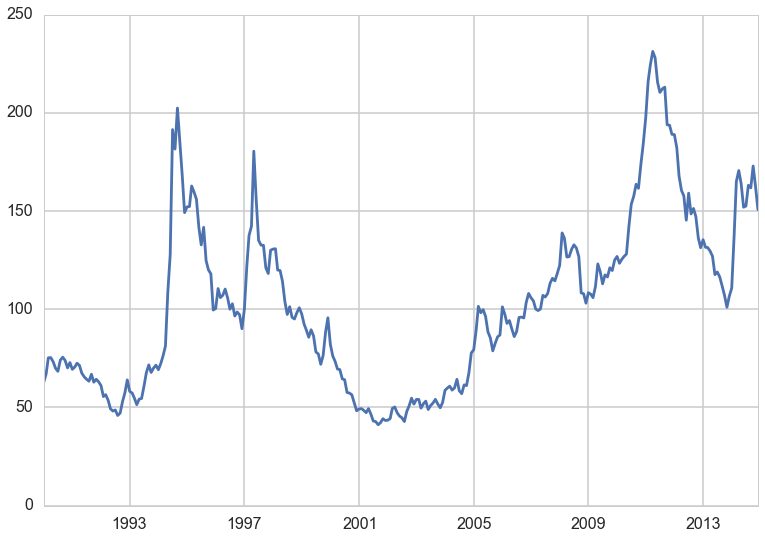

In [91]:
plt.plot(pricedf.index, pricedf["ICO composite indicator"])